In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [ ]:

try:
  import pynumdiff
except:
  !pip install git+https://github.com/florisvb/PyNumDiff
  import pynumdiff

  Cloning https://github.com/florisvb/PyNumDiff to /tmp/pip-req-build-1ff1kr0k
  Running command git clone --filter=blob:none --quiet https://github.com/florisvb/PyNumDiff /tmp/pip-req-build-1ff1kr0k
  Resolved https://github.com/florisvb/PyNumDiff to commit 8d22aa062b6e7b8f4c95f3addfe1c383fa43b597
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pynumdiff: filename=pynumdiff-0.1.4.dev257+g8d22aa062-py3-none-any.whl size=60236 sha256=b535d8e0b5a3a83e297e7a9c023c998f8b66594fc8e5bde4bfb16621e914f674
  Stored in directory: /tmp/pip-ephem-wheel-cache-7eh_i8x9/wheels/d5/d2/d5/e088d09db33998cc8a03da8ed5da944b4512c71615c0dc9e72
Successfully built pynumdiff


In [ ]:
try:
  import pysindy as ps
except:
  #!pip install git+https://github.com/dynamicslab/pysindy
  !pip install pysindy[miosr]
  import pysindy as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 2.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-8q5y8z74
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-8q5y8z74
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=3a53c72b9862745d20164136fa94fb05c2d0e3d3186b68d4bab4b2698f81d214
  Stored in directory: /tmp/pip-ephem-wheel-cache-phtakw19/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [ ]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now we will not include k as a static state. Instead, we will be using SINDy to find all the parameter values, which includes k.

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[lightblue]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[lightblue]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} + \bbox[lightblue]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Dynamics and measurement functions

Here we will use versions of `f` and `h` that do not consider $k$ to be a state.

In [ ]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

In [ ]:
print(f(None, None, return_state_names=True))

['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']


In [ ]:
print(h(None, None, return_measurement_names=True))

['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']


# Run MPC simulation

Here we need higher resolution trajectory, and more varied movements, to make the nonlinear system identification problem more feasible.

Relating back to observability -- our system identification is a much larger observability space so we need as much diversity in movement as possible.

Also requiring here to have smoother controls with a larger rterm.

In [ ]:
dt = 0.05
tsim_length = 40
tsim = np.arange(0, tsim_length, step=dt)

In [ ]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=dt, tsim_length=tsim_length,
                                                                    trajectory_shape='random', # this option helps with SINDy -- it makes the coefficients more observable
                                                                    rterm=1e-1) # a larger number here leads to smoother controls, which seems to help with SINDy

### Plot the x, z trajectory

Text(0, 0.5, 'z pos')

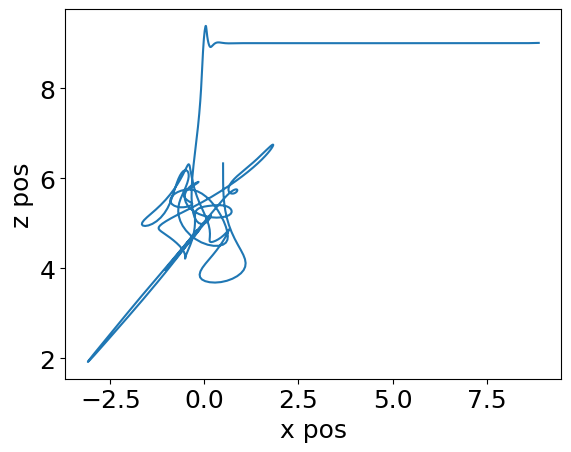

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

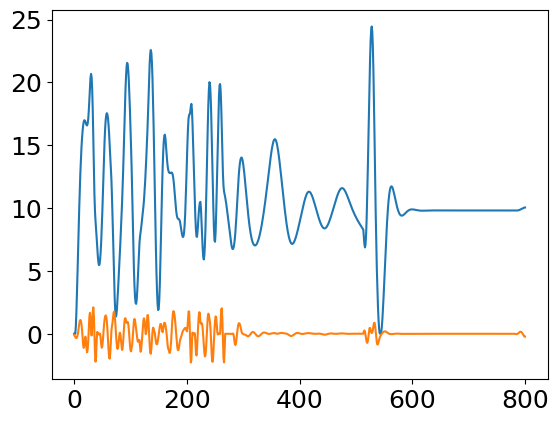

In [ ]:
plt.plot(u_sim['j2'])
plt.plot(u_sim['j1'])

In [ ]:
x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)

# Now add a little noise and pretend we have real data

Let's pretend we only had access to the following states and controls:

Measurements = $[\theta, x, z, j1, j2]$

And let's say they all have a little noise on them.

In [ ]:
noise_std = 0.1
state_x_noisy = x_sim_df['x'] + np.random.normal(0, noise_std, len(x_sim_df['x']))
state_z_noisy = x_sim_df['z'] + np.random.normal(0, noise_std, len(x_sim_df['z']))
state_theta_noisy = x_sim_df['theta'] + np.random.normal(0, 0.1*noise_std, len(x_sim_df['theta']))
state_j1_noisy = u_sim_df['j1'] + np.random.normal(0, noise_std, len(u_sim_df['j1']))
state_j2_noisy = u_sim_df['j2'] + np.random.normal(0, noise_std, len(u_sim_df['j2']))

### Compute naive numerical derivatives

There are many ways to do this. Here we use the Savitzky Golay filter, which is a frequency domain sliding polynomial fit.

Don't over smooth as that will introduce artificial dynamics.

<Axes: xlabel='Time', ylabel='x_dot'>

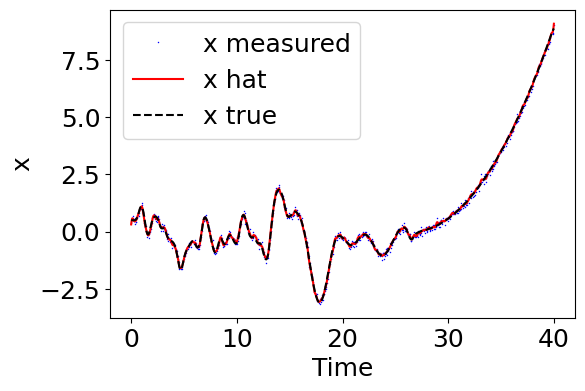

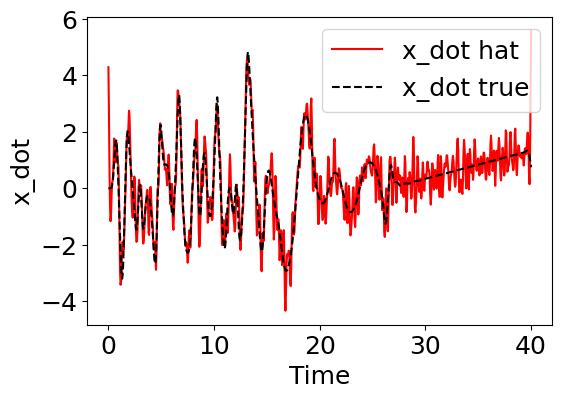

In [ ]:
state_x_smooth, state_xdot_smooth = pynumdiff.savgoldiff(state_x_noisy, dt, degree=3, window_size=7, smoothing_win=7)
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, state_x_smooth, label_var='x')
plot_tme(t_sim, x_sim_df['x_dot'], None, state_xdot_smooth, label_var='x_dot')

<Axes: xlabel='Time', ylabel='theta_dot'>

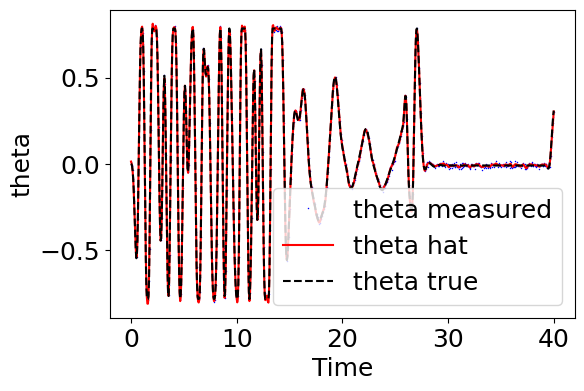

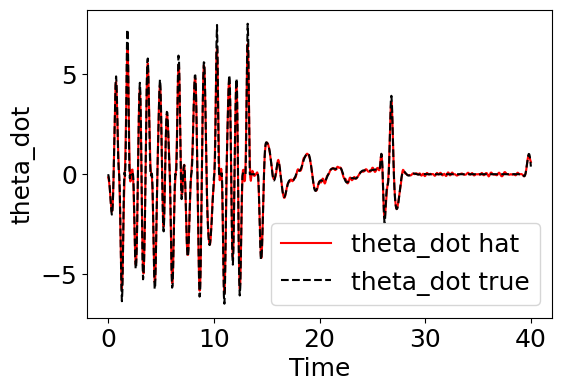

In [ ]:
state_theta_smooth, state_thetadot_smooth = pynumdiff.butterdiff(state_theta_noisy, dt, filter_order=4, cutoff_freq=0.3)
plot_tme(t_sim, x_sim_df['theta'], state_theta_noisy, state_theta_smooth, label_var='theta')
plot_tme(t_sim, x_sim_df['theta_dot'], None, state_thetadot_smooth, label_var='theta_dot')

<Axes: xlabel='Time', ylabel='zdot'>

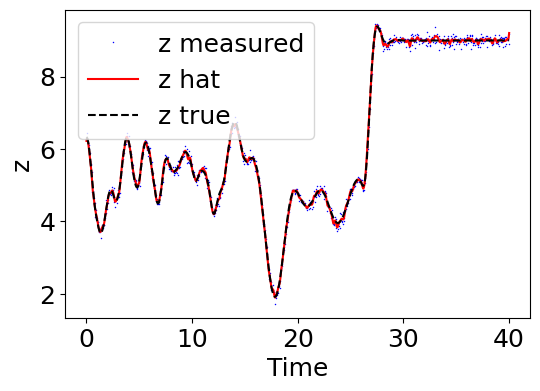

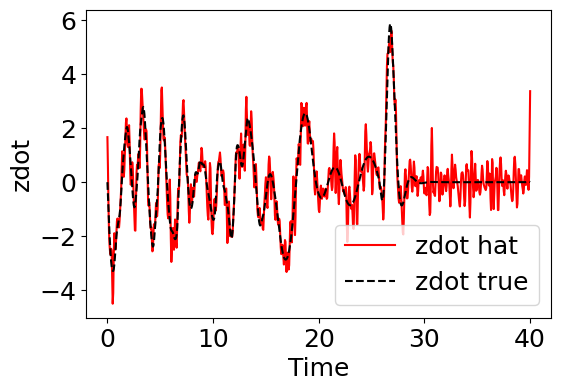

In [ ]:
state_z_smooth, state_zdot_smooth = pynumdiff.savgoldiff(state_z_noisy, dt, degree=3, window_size=7, smoothing_win=7)
plot_tme(t_sim, x_sim_df['z'], state_z_noisy, state_z_smooth, label_var='z')
plot_tme(t_sim, x_sim_df['z_dot'], None, state_zdot_smooth, label_var='zdot')

### Assemble state and controls for SINDy

In [ ]:
X = np.vstack((state_theta_noisy, state_thetadot_smooth,
               state_x_noisy, state_xdot_smooth,
               state_z_noisy, state_zdot_smooth)).T
U = u_sim_df.values

In [ ]:
dynamic_state_names = f(None, None, return_state_names=True)
control_input_names = ['j1', 'j2']

### Build a bespoke feature library

We can inject some knowledge here, for example:
  * let's use $\sin(\theta)$ and $\cos(\theta)$, but not include $\theta$ on its own
  * to make the library usable with default optimizer licenses, we can restrict it so we only try products of $j_{1,2}$ with $\sin(\theta)$ and $\cos(\theta)$ and not the other variables

In [ ]:
# First order polynomial library
poly_library = ps.PolynomialLibrary(degree=1)

# First order polynomial library -- we will use this to only extract the controls
# Don't include a bias (a constant) because the first library already has it
poly_library_ctrl = ps.PolynomialLibrary(degree=1, include_bias=False)

# Custom library that includes sin and cos of variable
# Don't include a bias (a constant) because the first library already has it
library_functions = [lambda x: np.sin( x ), lambda x: np.cos(x)]
library_function_names = [
    lambda x: "sin(" + x + ")",
    lambda x: "cos(" + x + ")",
]
sin_cos_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
sin_cos_library.library_functions = library_functions
sin_cos_library.function_names = library_function_names

# Initialize the default inputs, i.e. each library
# uses all the input variables, (6 states and 2 controls = 8 inputs and 2 libraries here)
inputs_temp = np.tile([0, 1, 2, 3, 4, 5, 6, 7], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 8))

inputs_per_library = [[1,2,3,4,5], [6,7], [0]]

# Tensor the control library and the sin, cos library together
tensor_array = [[0, 1, 1],]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, poly_library_ctrl, sin_cos_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

### Print out the library.. for some reason you have to fit it first

Here we use the default sequentially thresholded least squares optimizer (which does not do a good job).

In [ ]:
# Set up optimizer and model
optimizer = ps.optimizers.STLSQ()
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=t_sim,
          u=U,
          feature_names=dynamic_state_names + control_input_names)

model.get_feature_names()

#model.print()

['1',
 'theta_dot',
 'x',
 'x_dot',
 'z',
 'z_dot',
 'j1',
 'j2',
 'sin(theta)',
 'cos(theta)',
 'j1 sin(theta)',
 'j1 cos(theta)',
 'j2 sin(theta)',
 'j2 cos(theta)']

### Now run with MIO optimizer

Mixed Integer Optimization allows for a strict sparsity target that will really pare down the total terms that are left.

In [ ]:
# Set up optimizer and model
optimizer = ps.optimizers.MIOSR(target_sparsity=8)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=t_sim,
          u=U,
          feature_names=dynamic_state_names + control_input_names)

Restricted license - for non-production use only - expires 2026-11-23


SINDy(differentiation_method=FiniteDifference(),
      feature_library=GeneralizedLibrary(inputs_per_library=[[1, 2, 3, 4, 5],
                                                             [6, 7], [0]],
                                         libraries=[PolynomialLibrary(degree=1),
                                                    PolynomialLibrary(degree=1,
                                                                      include_bias=False),
                                                    CustomLibrary(function_names=[<function <lambda> at 0x7ce60536e5c0>,
                                                                                  <function <lambda> at 0x7ce60536e520>],
                                                                  library_functions=[<function <lambda> at 0x7ce60536d620>,
                                                                                     <function <lambda> at 0x7ce60536e700>])],
                                         tensor_array=[[0, 1, 1]]),
      optimizer=MIOSR(target_sparsity=8))

In [ ]:
model.print()

(theta)' = 1.006 theta_dot
(theta_dot)' = 1.140 theta_dot + 21.463 j1
(x)' = 1.152 x_dot
(x_dot)' = -0.912 j2 sin(theta)
(z)' = 1.133 z_dot
(z_dot)' = -9.599 1 + 0.984 j2 cos(theta)


### Compare predicted derivatives to true derivatives

Make a true vs predicted plot for each state. Note that this is cheating -- you would not have access to this if all you had was real data.

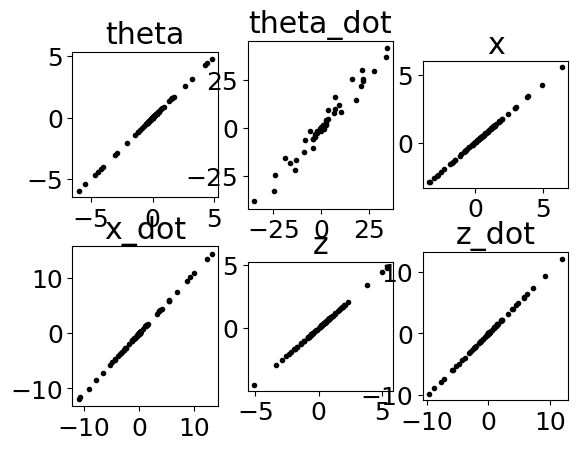

In [ ]:
fig = plt.figure()

for s in range(6):
  ax = fig.add_subplot(2,3,s+1)
  ax.set_aspect('equal')

  for k in range(0, X.shape[0], 10):

    sindy_xdot = model.predict(X[k:k+1,:], U[k:k+1,:])[0]
    true_xdot = f(X[k,:], U[k,:])

    ax.plot(sindy_xdot[s], true_xdot[s], '.', color='black')
    ax.set_title(dynamic_state_names[s])

### Compare predicted derivatives to naive numerical derivatives

This is feasible in real life. You can numerically differentiate the data and compare the the SINDy model predictions.

As expected, the 2nd derivatives are not great.

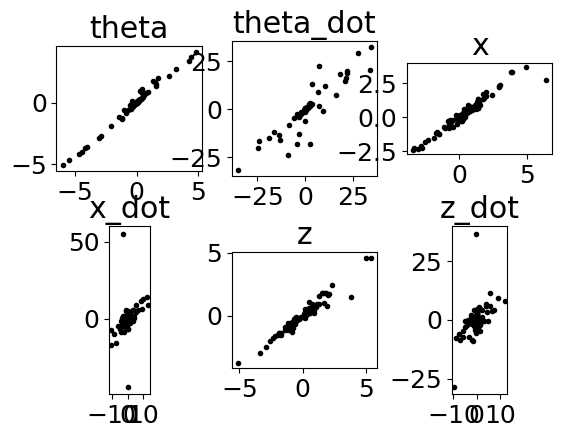

In [ ]:
fig = plt.figure()

for s in range(6):
  ax = fig.add_subplot(2,3,s+1)
  ax.set_aspect('equal')

  _, ddt_state = pynumdiff.savgoldiff(X[:,s], dt, degree=3, window_size=9, smoothing_win=9)

  for k in range(0, X.shape[0], 10):

    sindy_xdot = model.predict(X[k:k+1,:], U[k:k+1,:])[0]

    ax.plot(sindy_xdot[s], ddt_state[k], '.', color='black')
    ax.set_title(dynamic_state_names[s])

# Implement model with a UKF

Now let's use the SINDy model with a UKF.

To test the UKF we return to the same "squiggle" trajectory and larger dt that we used in the original UKF example.  

In [ ]:
# pysindy has a different format than our UKF expects
def f_wrapper(x, u):
  x_reshaped = np.atleast_2d(x)
  u_reshaped = np.atleast_2d(u)
  return np.ravel(model.predict(x_reshaped, u_reshaped))

In [ ]:
testing_data = planar_drone.simulate_drone(f, h, dt=0.1, tsim_length=20)
t_test = testing_data[0]
x_test = testing_data[1]
u_test = testing_data[2]
y_test = testing_data[3] # t_sim, x_sim, u_sim, y_sim, simulator

In [ ]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                         }

In [ ]:
y_noisy = {key: y_test[key] + np.random.normal(0, measurement_noise_stds[key], len(y_test[key])) for key in y_test.keys()}

In [ ]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_test)
x_sim_df = pd.DataFrame(x_test)

In [ ]:
x0 = np.ones(len(x_sim))*2
u0 = np.zeros(2)
P0 = np.eye(len(x_sim))*1

R = np.diag( list(measurement_noise_stds.values()) )**2

# Note different values along diagonal here, tuned to make the filter work better.
# The values now reflect the trust in the model -- low trust in the thetadot eqn
Q = np.diag([1e-4, 1e-1, 1e-4, 1e-3, 1e-4, 1e-3])


dt = np.mean(np.diff(t_sim))

In [ ]:
UKF = unscented_kalman_filter.UKF(f_wrapper, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.001)

In [ ]:
UKF.estimate(y_noisy_df, u_sim_df)

In [ ]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

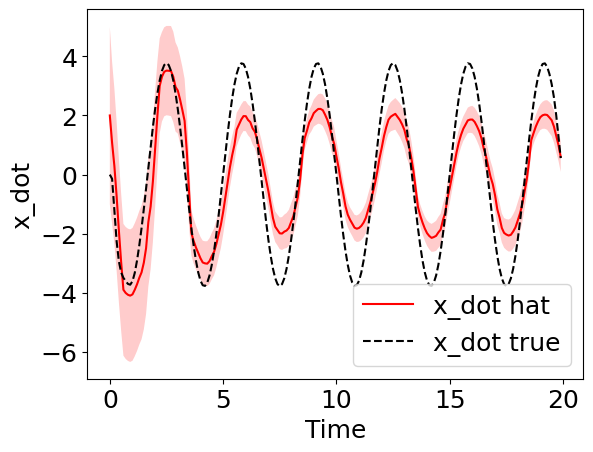

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_test, x_test[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_test, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

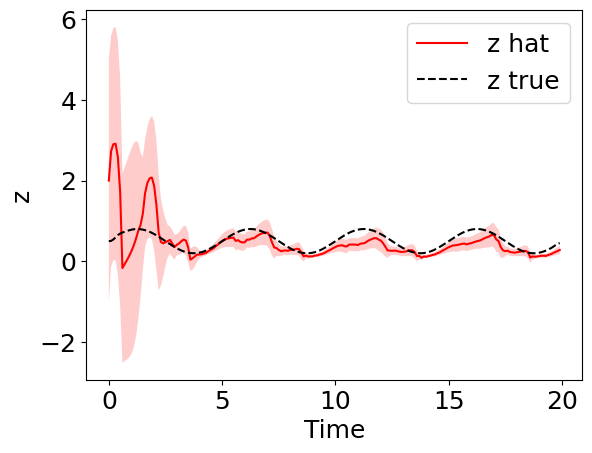

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_test, x_test[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_test, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Conclusion

There is some room for improvement in the model, but it does an okay job.

# Exercises:

1. Try some of the other optimizers in pysindy:
  * STLSQ
  * SSR
2. Make the SINDy library more exhaustive
  * Note: to use MIOSR with a bigger library you will need to register for a gurobipy license (free for academic email on academic network).